# 🔍 Systematic EDA Methodology - Class 5
## Uni/Bi/Multivariate Analysis with Practical Examples

**Author:** Julian Eduardo Garzon Giraldo, MsC  
**Date:** Week 5 - Preparation for Delivery 1

---

This notebook contains practical examples of each concept presented in the slides.

## 📦 Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Visualization configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Seed for reproducibility
np.random.seed(42)

## 📊 Slide 2: Main Dataset Generation

Let's create a sales dataset for a company with multiple branches to apply all concepts.

In [2]:
# Corporate sales dataset generation
np.random.seed(42)
n = 1000

# Categorical variables
departments = np.random.choice(['Bogota', 'Medellin', 'Cali', 'Barranquilla', 'Cartagena'], n)
zones = np.random.choice(['Urban', 'Rural'], n, p=[0.7, 0.3])
sectors = np.random.choice(['Retail', 'Wholesale', 'Online'], n, p=[0.5, 0.3, 0.2])
categories = np.random.choice(['Electronics', 'Clothing', 'Food', 'Home'], n)

# Numerical variables with different distributions
# Sales - right-skewed distribution (log-normal)
sales = np.random.lognormal(8, 1.5, n)

# Customer age - bimodal distribution (mixture of two normals)
age_group1 = np.random.normal(25, 5, n//2)
age_group2 = np.random.normal(55, 8, n//2)
customer_age = np.concatenate([age_group1, age_group2])
np.random.shuffle(customer_age)

# Satisfaction - normal distribution
satisfaction = np.random.normal(7.5, 1.5, n)
satisfaction = np.clip(satisfaction, 1, 10)  # Limit between 1 and 10

# Number of products - Poisson distribution
num_products = np.random.poisson(3, n) + 1

# Applied discount - correlated with sales
discount = 5 + (sales / sales.max()) * 15 + np.random.normal(0, 3, n)
discount = np.clip(discount, 0, 30)

# Customer tenure (months) - exponential
customer_tenure = np.random.exponential(24, n)

# Create DataFrame
df = pd.DataFrame({
    'department': departments,
    'zone': zones,
    'sector': sectors,
    'category': categories,
    'sales': sales,
    'customer_age': customer_age.astype(int),
    'satisfaction': satisfaction.round(1),
    'num_products': num_products,
    'discount': discount.round(1),
    'customer_tenure_months': customer_tenure.round(0)
})

# Introduce some null values for data cleaning practice
df.loc[np.random.choice(df.index, 50, replace=False), 'satisfaction'] = np.nan
df.loc[np.random.choice(df.index, 30, replace=False), 'discount'] = np.nan

print("📊 Dataset Created:")
print(f"Dimensions: {df.shape}")
print(f"\nFirst 5 rows:")
df.head()

📊 Dataset Created:
Dimensions: (1000, 10)

First 5 rows:


,department,zone,sector,category,sales,customer_age,satisfaction,num_products,discount,customer_tenure_months
0,Barranquilla,Rural,Wholesale,Food,1199.847276,20,9.1,2,5.0,5.0
1,Cartagena,Urban,Retail,Clothing,4092.558233,62,6.9,5,8.4,77.0
2,Cali,Urban,Retail,Clothing,18035.880874,25,8.9,4,10.5,24.0
3,Cartagena,Rural,Retail,Clothing,1425.312446,45,7.7,3,10.5,45.0
4,Cartagena,Rural,Online,Clothing,178.603978,47,7.3,3,1.2,19.0


In [3]:
# General dataset information
print("📋 Dataset Information:")
print("="*50)
df.info()
print("\n📊 Descriptive Statistics:")
print("="*50)
df.describe()

📋 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   department              1000 non-null   object 
 1   zone                    1000 non-null   object 
 2   sector                  1000 non-null   object 
 3   category                1000 non-null   object 
 4   sales                   1000 non-null   float64
 5   customer_age            1000 non-null   int64  
 6   satisfaction            950 non-null    float64
 7   num_products            1000 non-null   int64  
 8   discount                970 non-null    float64
 9   customer_tenure_months  1000 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 78.3+ KB

📊 Descriptive Statistics:


,sales,customer_age,satisfaction,num_products,discount,customer_tenure_months
count,1.000000e+03,1000.000000,950.000000,1000.00000,970.000000,1000.000000
mean,9.827680e+03,39.085000,7.401474,3.93900,5.130412,24.096000
std,3.766182e+04,16.214459,1.434079,1.66675,2.876282,24.807503
min,3.355870e+01,10.000000,3.200000,1.00000,0.000000,0.000000
25%,1.030746e+03,24.000000,6.400000,3.00000,3.100000,6.000000
50%,3.044497e+03,35.000000,7.400000,4.00000,5.000000,16.000000
75%,8.372659e+03,54.000000,8.400000,5.00000,7.000000,34.000000
max,1.076641e+06,73.000000,10.000000,11.00000,21.800000,162.000000


## 📈 Slide 4: Types of Distributions

Let's visualize the three main types of distributions with our data.

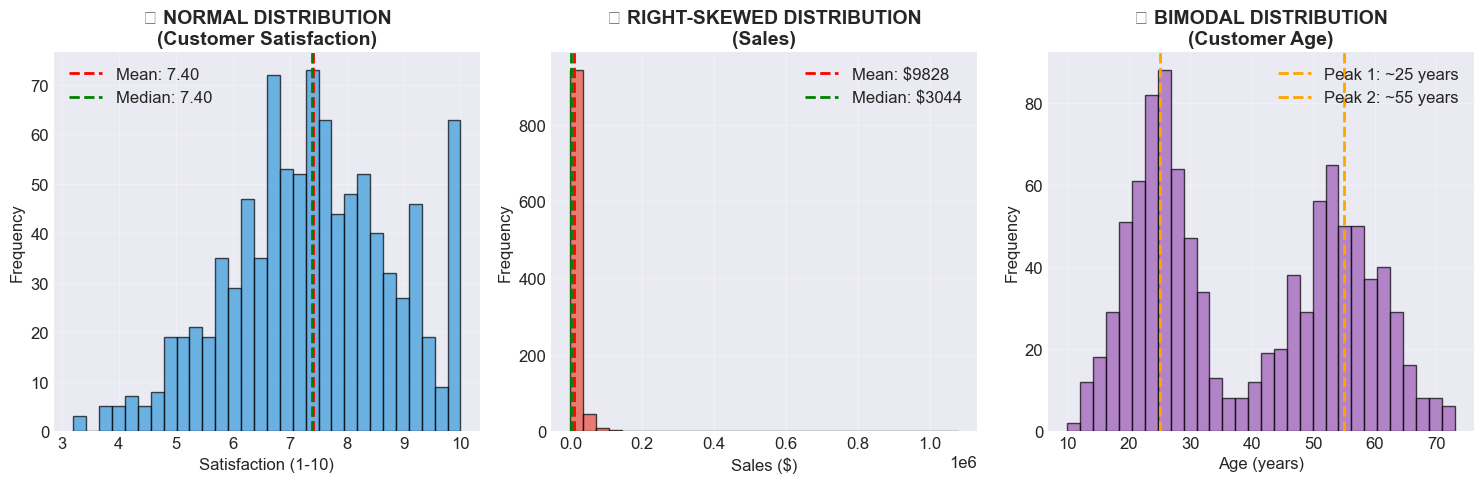


📊 Skewness Analysis:
Satisfaction (Normal): -0.161 → Symmetric (close to 0)
Sales (Skewed): 23.229 → Strongly right-skewed (> 1)
Age (Bimodal): 0.179 → Slightly skewed


In [17]:
# Visualization of the three types of distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Normal Distribution - Satisfaction
ax1 = axes[0]
df['satisfaction'].dropna().hist(bins=30, ax=ax1, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(df['satisfaction'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["satisfaction"].mean():.2f}')
ax1.axvline(df['satisfaction'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["satisfaction"].median():.2f}')
ax1.set_title('🔵 NORMAL DISTRIBUTION\n(Customer Satisfaction)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Satisfaction (1-10)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Right-Skewed Distribution - Sales
ax2 = axes[1]
df['sales'].hist(bins=30, ax=ax2, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.axvline(df['sales'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df["sales"].mean():.0f}')
ax2.axvline(df['sales'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${df["sales"].median():.0f}')
ax2.set_title('🔴 RIGHT-SKEWED DISTRIBUTION\n(Sales)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sales ($)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Bimodal Distribution - Age
ax3 = axes[2]
df['customer_age'].hist(bins=30, ax=ax3, color='#9b59b6', edgecolor='black', alpha=0.7)
ax3.axvline(25, color='orange', linestyle='--', linewidth=2, label='Peak 1: ~25 years')
ax3.axvline(55, color='orange', linestyle='--', linewidth=2, label='Peak 2: ~55 years')
ax3.set_title('🟣 BIMODAL DISTRIBUTION\n(Customer Age)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Age (years)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Skewness analysis
print("\n📊 Skewness Analysis:")
print("="*50)
print(f"Satisfaction (Normal): {df['satisfaction'].skew():.3f} → Symmetric (close to 0)")
print(f"Sales (Skewed): {df['sales'].skew():.3f} → Strongly right-skewed (> 1)")
print(f"Age (Bimodal): {df['customer_age'].skew():.3f} → Slightly skewed")

## 🔍 Slide 5: Univariate Analysis Framework

We apply the systematic 5-step checklist for univariate analysis.


📊 UNIVARIATE ANALYSIS: SALES


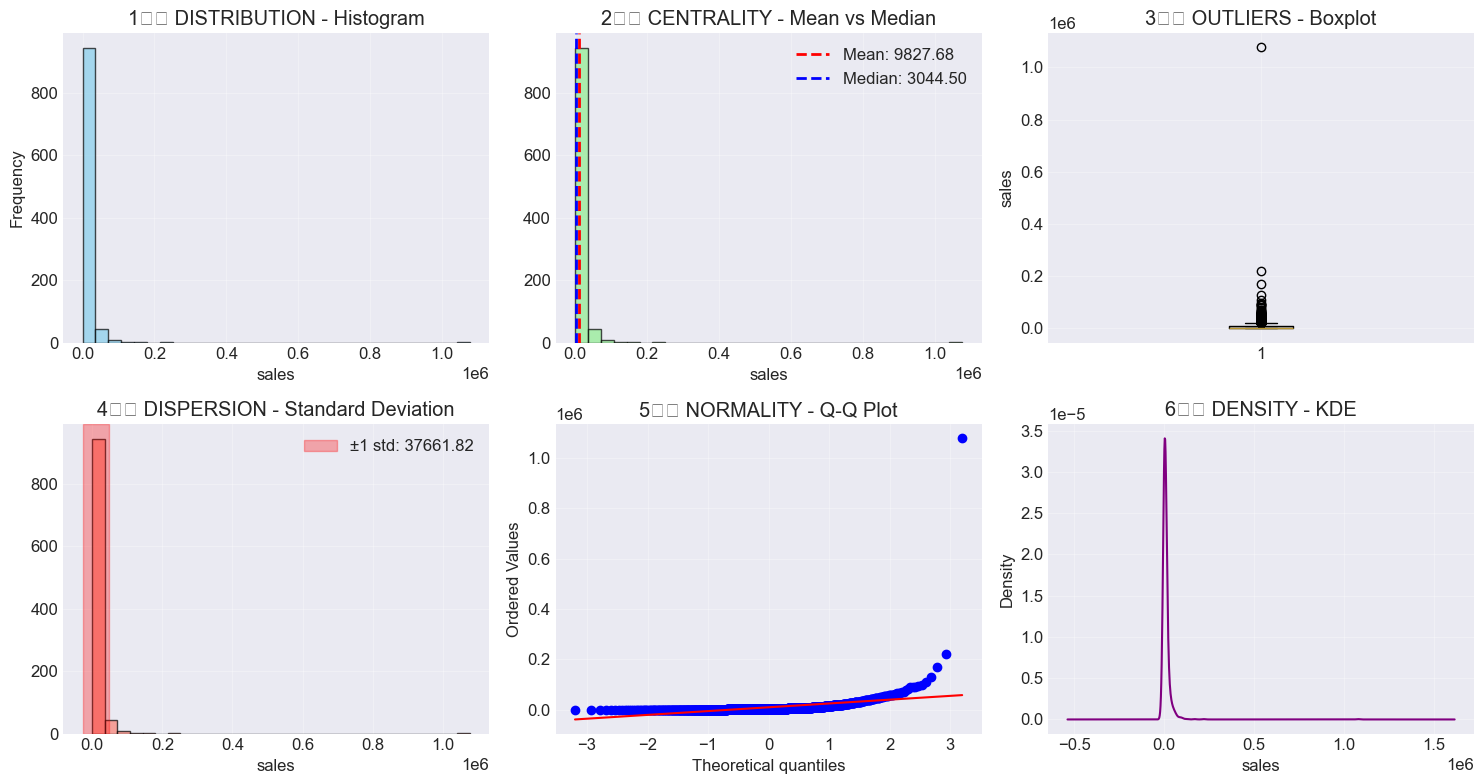


📈 DESCRIPTIVE STATISTICS:
----------------------------------------
Count: 1000
Mean: 9827.68
Median: 3044.50
Mode: 33.56
Std Deviation: 37661.82
Coef. Variation: 383.22%
Minimum: 33.56
Q1 (25%): 1030.75
Q2 (50%): 3044.50
Q3 (75%): 8372.66
Maximum: 1076640.99
Range: 1076607.43
IQR: 7341.91
Skewness: 23.229
Kurtosis: 647.001

🚨 OUTLIERS DETECTED: 121 (12.1%)
Outlier values (first 10): [20177.2812916  26469.10501146 24727.93160228 24466.37378415
 38174.99739562 44979.38373713 29112.58650123 25515.72410681
 21881.56935042 60986.36957222]


In [5]:
def complete_univariate_analysis(df, variable, type='numeric'):
    """
    Systematic framework for univariate analysis
    """
    print(f"\n{'='*60}")
    print(f"📊 UNIVARIATE ANALYSIS: {variable.upper()}")
    print(f"{'='*60}")
    
    if type == 'numeric':
        data = df[variable].dropna()
        
        # 1. DISTRIBUTION
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        
        # Histogram
        axes[0, 0].hist(data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('1️⃣ DISTRIBUTION - Histogram')
        axes[0, 0].set_xlabel(variable)
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. CENTRALITY
        mean = data.mean()
        median = data.median()
        mode = data.mode()[0] if len(data.mode()) > 0 else None
        
        axes[0, 1].hist(data, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
        axes[0, 1].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
        axes[0, 1].axvline(median, color='blue', linestyle='--', linewidth=2, label=f'Median: {median:.2f}')
        axes[0, 1].set_title('2️⃣ CENTRALITY - Mean vs Median')
        axes[0, 1].set_xlabel(variable)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. OUTLIERS - Boxplot
        axes[0, 2].boxplot(data, vert=True)
        axes[0, 2].set_title('3️⃣ OUTLIERS - Boxplot')
        axes[0, 2].set_ylabel(variable)
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. DISPERSION
        std = data.std()
        cv = (std / mean) * 100  # Coefficient of variation
        
        axes[1, 0].hist(data, bins=30, color='salmon', edgecolor='black', alpha=0.7)
        axes[1, 0].axvspan(mean - std, mean + std, alpha=0.3, color='red', label=f'±1 std: {std:.2f}')
        axes[1, 0].set_title('4️⃣ DISPERSION - Standard Deviation')
        axes[1, 0].set_xlabel(variable)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Q-Q PLOT for normality
        stats.probplot(data, dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title('5️⃣ NORMALITY - Q-Q Plot')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Density
        data.plot(kind='density', ax=axes[1, 2], color='purple')
        axes[1, 2].set_title('6️⃣ DENSITY - KDE')
        axes[1, 2].set_xlabel(variable)
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print("\n📈 DESCRIPTIVE STATISTICS:")
        print("-"*40)
        print(f"Count: {len(data)}")
        print(f"Mean: {mean:.2f}")
        print(f"Median: {median:.2f}")
        print(f"Mode: {mode:.2f}" if mode else "Mode: Not defined")
        print(f"Std Deviation: {std:.2f}")
        print(f"Coef. Variation: {cv:.2f}%")
        print(f"Minimum: {data.min():.2f}")
        print(f"Q1 (25%): {data.quantile(0.25):.2f}")
        print(f"Q2 (50%): {data.quantile(0.50):.2f}")
        print(f"Q3 (75%): {data.quantile(0.75):.2f}")
        print(f"Maximum: {data.max():.2f}")
        print(f"Range: {data.max() - data.min():.2f}")
        print(f"IQR: {data.quantile(0.75) - data.quantile(0.25):.2f}")
        print(f"Skewness: {data.skew():.3f}")
        print(f"Kurtosis: {data.kurtosis():.3f}")
        
        # Outlier detection
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)]
        
        print(f"\n🚨 OUTLIERS DETECTED: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
        if len(outliers) > 0:
            print(f"Outlier values (first 10): {outliers.head(10).values}")

# Apply the framework to different variables
complete_univariate_analysis(df, 'sales')

In [ ]:
# Univariate analysis of satisfaction
complete_univariate_analysis(df, 'satisfaction')

## 🔗 Slide 6: Bivariate Analysis - Types of Relationships

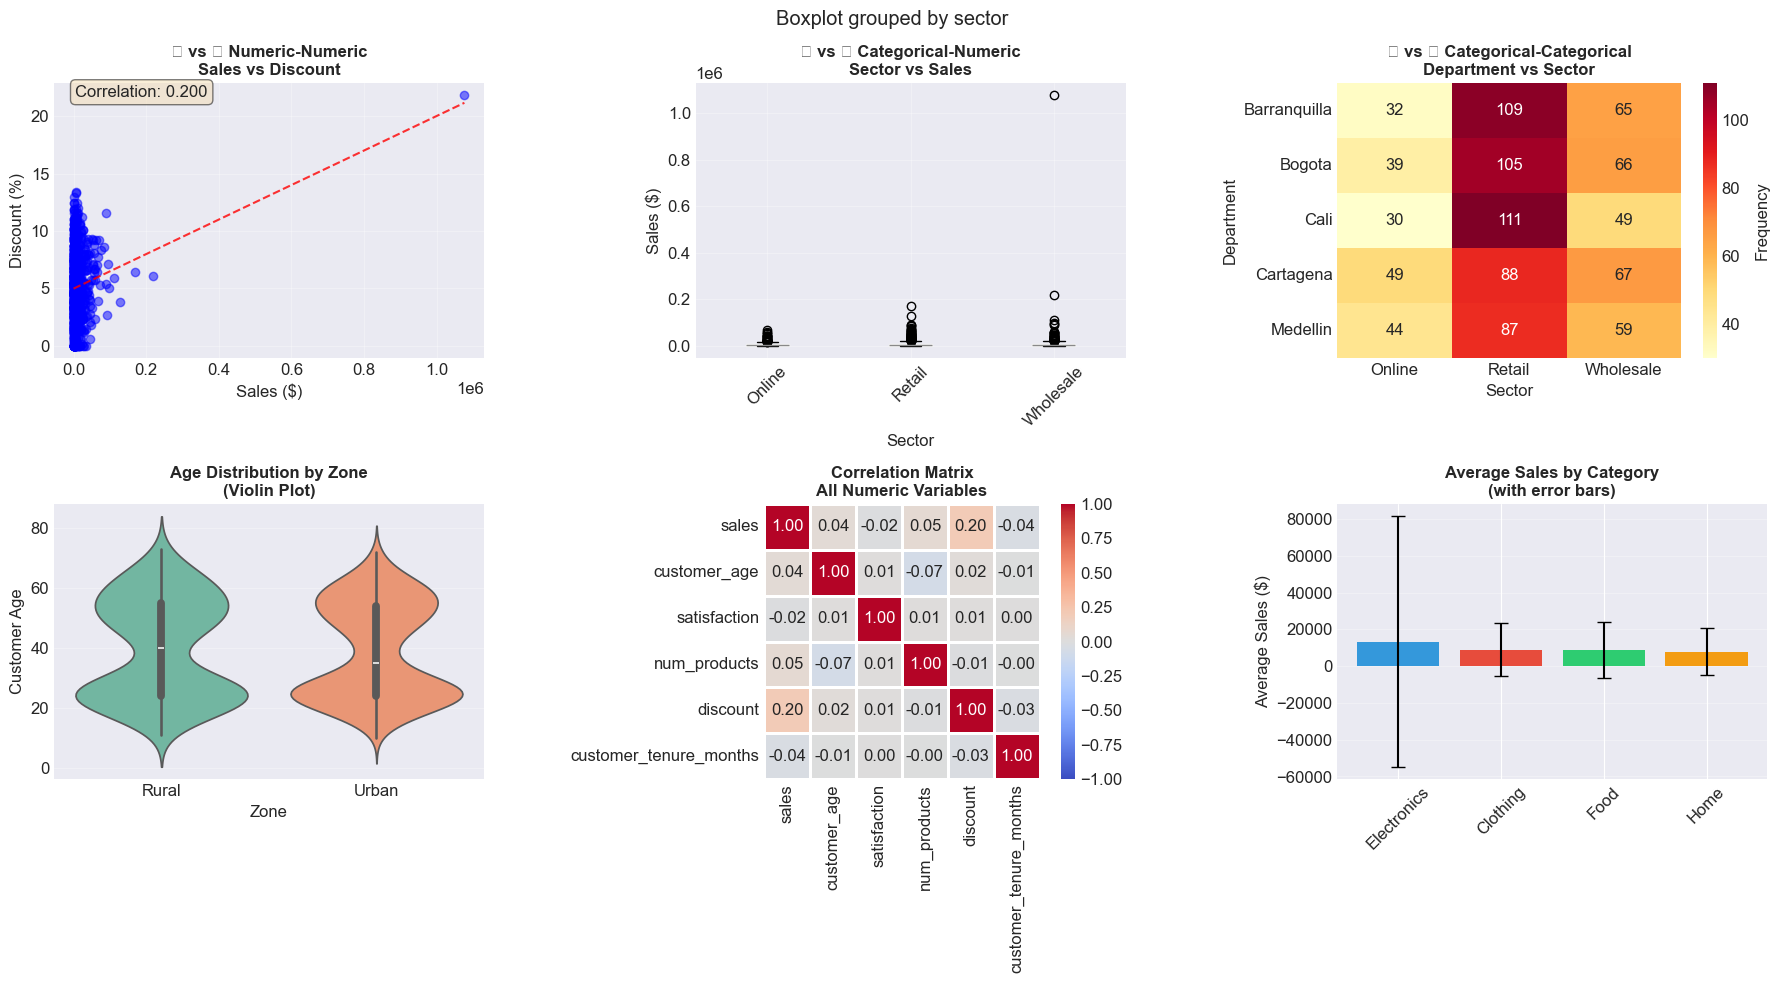

In [6]:
# Create visualization of the 3 types of bivariate analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. NUMERIC vs NUMERIC - Scatter plot with correlation
ax1 = axes[0, 0]
# Filter out NaN values for both variables together
valid_mask = df['sales'].notna() & df['discount'].notna()
sales_clean = df.loc[valid_mask, 'sales']
discount_clean = df.loc[valid_mask, 'discount']

ax1.scatter(sales_clean, discount_clean, alpha=0.5, color='blue')
ax1.set_title('🔢 vs 🔢 Numeric-Numeric\nSales vs Discount', fontsize=12, fontweight='bold')
ax1.set_xlabel('Sales ($)')
ax1.set_ylabel('Discount (%)')
correlation = sales_clean.corr(discount_clean)
ax1.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax1.grid(True, alpha=0.3)

# Regression line with clean data
if len(sales_clean) > 1:
    z = np.polyfit(sales_clean, discount_clean, 1)
    p = np.poly1d(z)
    ax1.plot(sales_clean.sort_values(), p(sales_clean.sort_values()), "r--", alpha=0.8)

# 2. CATEGORICAL vs NUMERIC - Boxplot
ax2 = axes[0, 1]
df.boxplot(column='sales', by='sector', ax=ax2)
ax2.set_title('📂 vs 🔢 Categorical-Numeric\nSector vs Sales', fontsize=12, fontweight='bold')
ax2.set_xlabel('Sector')
ax2.set_ylabel('Sales ($)')
plt.sca(ax2)
plt.xticks(rotation=45)
ax2.grid(True, alpha=0.3)

# 3. CATEGORICAL vs CATEGORICAL - Crosstab heatmap
ax3 = axes[0, 2]
cross_tab = pd.crosstab(df['department'], df['sector'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Frequency'})
ax3.set_title('📂 vs 📂 Categorical-Categorical\nDepartment vs Sector', fontsize=12, fontweight='bold')
ax3.set_xlabel('Sector')
ax3.set_ylabel('Department')

# 4. Violin plot for distribution comparison
ax4 = axes[1, 0]
sns.violinplot(data=df, x='zone', y='customer_age', ax=ax4, palette='Set2')
ax4.set_title('Age Distribution by Zone\n(Violin Plot)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Zone')
ax4.set_ylabel('Customer Age')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Correlation matrix
ax5 = axes[1, 1]
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax5,
            vmin=-1, vmax=1, square=True, linewidths=1)
ax5.set_title('Correlation Matrix\nAll Numeric Variables', fontsize=12, fontweight='bold')

# 6. Barplot with confidence intervals
ax6 = axes[1, 2]
mean_sales = df.groupby('category')['sales'].mean().sort_values(ascending=False)
std_sales = df.groupby('category')['sales'].std()
x_pos = np.arange(len(mean_sales))
ax6.bar(x_pos, mean_sales.values, yerr=std_sales[mean_sales.index].values, 
        capsize=5, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax6.set_xticks(x_pos)
ax6.set_xticklabels(mean_sales.index, rotation=45)
ax6.set_title('Average Sales by Category\n(with error bars)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Average Sales ($)')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 📈 Slide 7: Correlations - Correct Interpretation

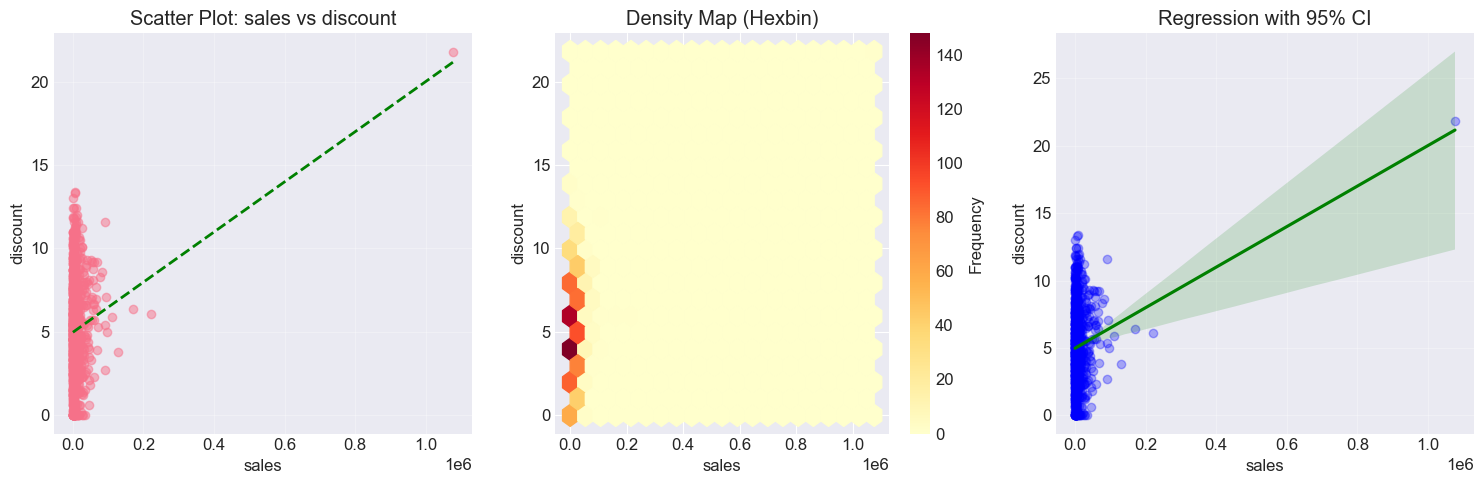


📊 CORRELATION ANALYSIS: sales vs discount

📈 Correlation Coefficient (r): 0.1995
📊 Valid data points used: 970

🎯 Interpretation:
   Strength: 🟢 WEAK (|r| = 0.200)
   Direction: POSITIVE ↗

📝 Meaning:
   📉 WEAK or no linear relationship.
   📉 Little linear association between variables.
   🔍 Consider: non-linear relationships or segmentation.

⚠️  Reminder: CORRELATION ≠ CAUSATION

📊 R² (Coefficient of Determination): 0.0398
   → discount explains 4.0% of the variability in sales


In [7]:
def interpret_correlation(var1, var2, data):
    """
    Function to automatically interpret correlation between two variables
    """
    # Filter out NaN values for both variables together
    valid_mask = data[var1].notna() & data[var2].notna()
    clean_data = data.loc[valid_mask, [var1, var2]]
    
    if len(clean_data) < 2:
        print(f"Error: Not enough valid data points for correlation analysis")
        return
    
    # Calculate correlation
    correlation = clean_data[var1].corr(clean_data[var2])
    
    # Strength interpretation
    abs_corr = abs(correlation)
    if abs_corr > 0.7:
        strength = "🔴 STRONG"
        color = 'red'
    elif abs_corr > 0.3:
        strength = "🟡 MODERATE"
        color = 'orange'
    else:
        strength = "🟢 WEAK"
        color = 'green'
    
    direction = "POSITIVE ↗" if correlation > 0 else "NEGATIVE ↘"
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Scatter plot with regression line
    ax1 = axes[0]
    ax1.scatter(clean_data[var1], clean_data[var2], alpha=0.5)
    
    # Add regression line only if we have enough points
    if len(clean_data) > 1:
        z = np.polyfit(clean_data[var1], clean_data[var2], 1)
        p = np.poly1d(z)
        x_sorted = clean_data[var1].sort_values()
        ax1.plot(x_sorted, p(x_sorted), color=color, linewidth=2, linestyle='--')
    
    ax1.set_xlabel(var1)
    ax1.set_ylabel(var2)
    ax1.set_title(f'Scatter Plot: {var1} vs {var2}')
    ax1.grid(True, alpha=0.3)
    
    # Hexbin plot for density
    ax2 = axes[1]
    hexbin = ax2.hexbin(clean_data[var1], clean_data[var2], gridsize=20, cmap='YlOrRd')
    ax2.set_xlabel(var1)
    ax2.set_ylabel(var2)
    ax2.set_title('Density Map (Hexbin)')
    plt.colorbar(hexbin, ax=ax2, label='Frequency')
    
    # Regression with confidence interval
    ax3 = axes[2]
    sns.regplot(x=var1, y=var2, data=clean_data, ax=ax3, color='blue',
                scatter_kws={'alpha': 0.3}, line_kws={'color': color})
    ax3.set_xlabel(var1)
    ax3.set_ylabel(var2)
    ax3.set_title('Regression with 95% CI')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    print("\n" + "="*60)
    print(f"📊 CORRELATION ANALYSIS: {var1} vs {var2}")
    print("="*60)
    print(f"\n📈 Correlation Coefficient (r): {correlation:.4f}")
    print(f"📊 Valid data points used: {len(clean_data)}")
    print(f"\n🎯 Interpretation:")
    print(f"   Strength: {strength} (|r| = {abs_corr:.3f})")
    print(f"   Direction: {direction}")
    print(f"\n📝 Meaning:")
    
    if abs_corr > 0.7:
        print(f"   ⚡ VERY STRONG relationship between variables.")
        print(f"   ⚡ Changes in {var1} are strongly associated with changes in {var2}.")
        print(f"   ⚠️  IMPORTANT: Investigate possible causality or confounding variable.")
    elif abs_corr > 0.3:
        print(f"   📍 MODERATE relationship between variables.")
        print(f"   📍 Clear association exists but with variability.")
        print(f"   💡 Useful for predictive models with other variables.")
    else:
        print(f"   📉 WEAK or no linear relationship.")
        print(f"   📉 Little linear association between variables.")
        print(f"   🔍 Consider: non-linear relationships or segmentation.")
    
    print(f"\n⚠️  Reminder: CORRELATION ≠ CAUSATION")
    
    # Coefficient of determination
    r_squared = correlation ** 2
    print(f"\n📊 R² (Coefficient of Determination): {r_squared:.4f}")
    print(f"   → {var2} explains {r_squared*100:.1f}% of the variability in {var1}")

# Analyze different correlations
interpret_correlation('sales', 'discount', df)

In [ ]:
# Analyze another correlation
interpret_correlation('satisfaction', 'customer_tenure_months', df.dropna())

## 🌐 Slide 8: Introduction to Multivariate Analysis

🔄 SIMPSON'S PARADOX EXAMPLE

📊 Overall Correlation (sales vs satisfaction): -0.015

📍 Correlation by Zone:
   Rural: -0.012
   Urban: -0.016


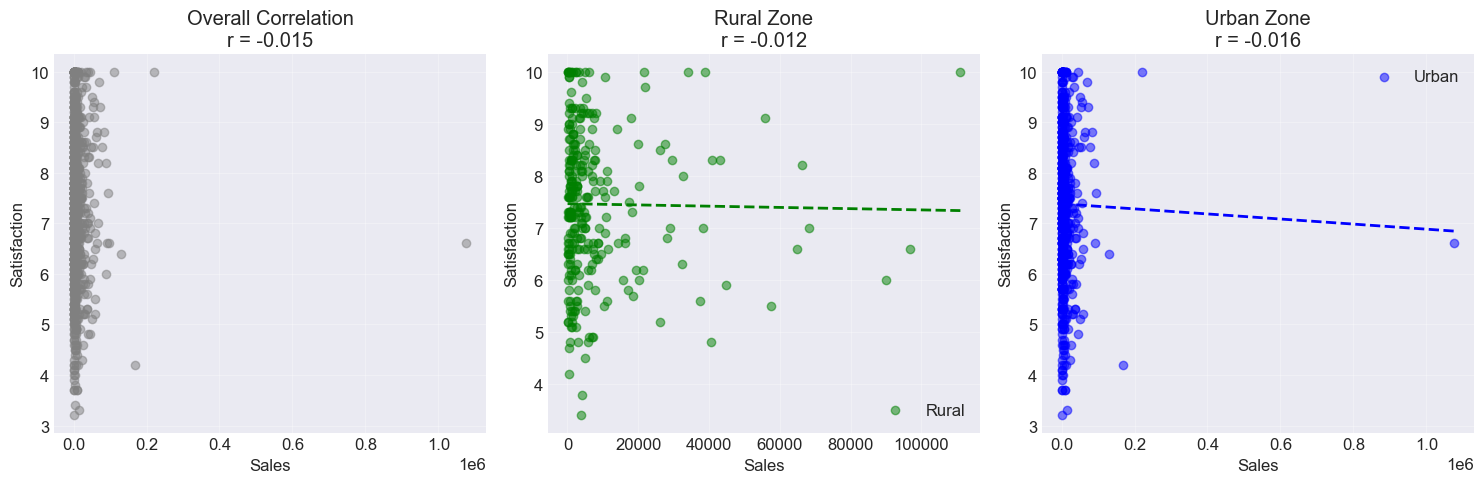


💡 Insight: The relationship between sales and satisfaction can change by zone!


In [8]:
# Simpson's Paradox Example
print("🔄 SIMPSON'S PARADOX EXAMPLE")
print("="*60)

# Overall correlation between sales and satisfaction
overall_corr = df['sales'].corr(df['satisfaction'])
print(f"\n📊 Overall Correlation (sales vs satisfaction): {overall_corr:.3f}")

# Correlation by zone
print("\n📍 Correlation by Zone:")
for zone in df['zone'].unique():
    subset = df[df['zone'] == zone]
    zone_corr = subset['sales'].corr(subset['satisfaction'])
    print(f"   {zone}: {zone_corr:.3f}")

# Effect visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Overall plot
ax1 = axes[0]
# Filter valid data for overall plot
overall_mask = df['sales'].notna() & df['satisfaction'].notna()
overall_clean = df.loc[overall_mask, ['sales', 'satisfaction']]

ax1.scatter(overall_clean['sales'], overall_clean['satisfaction'], alpha=0.5, color='gray')
ax1.set_title(f'Overall Correlation\nr = {overall_corr:.3f}')
ax1.set_xlabel('Sales')
ax1.set_ylabel('Satisfaction')
ax1.grid(True, alpha=0.3)

# Plot by zones separately
colors = {'Urban': 'blue', 'Rural': 'green'}
for i, zone in enumerate(df['zone'].unique()):
    subset = df[df['zone'] == zone]
    # Filter valid data for this zone
    zone_mask = subset['sales'].notna() & subset['satisfaction'].notna()
    subset_clean = subset.loc[zone_mask, ['sales', 'satisfaction']]
    
    if len(subset_clean) > 1:
        ax = axes[i+1]
        ax.scatter(subset_clean['sales'], subset_clean['satisfaction'], 
                   alpha=0.5, color=colors[zone], label=zone)
        
        # Trend line
        z = np.polyfit(subset_clean['sales'], subset_clean['satisfaction'], 1)
        p = np.poly1d(z)
        x_sorted = subset_clean['sales'].sort_values()
        ax.plot(x_sorted, p(x_sorted), color=colors[zone], linewidth=2, linestyle='--')
        
        corr = subset_clean['sales'].corr(subset_clean['satisfaction'])
        ax.set_title(f'{zone} Zone\nr = {corr:.3f}')
        ax.set_xlabel('Sales')
        ax.set_ylabel('Satisfaction')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Insight: The relationship between sales and satisfaction can change by zone!")

## ⚙️ Slide 9: Advanced GroupBy for EDA

In [9]:
# Basic vs Advanced GroupBy
print("🔰 BASIC GROUPBY")
print("="*60)
print("\nSimple average by department:")
print(df.groupby('department')['sales'].mean().round(2))

print("\n" + "="*60)
print("🚀 ADVANCED GROUPBY")
print("="*60)

# Multiple aggregation with different functions
advanced_aggregation = df.groupby('department').agg({
    'sales': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'satisfaction': ['mean', 'std'],
    'customer_age': ['mean', 'median'],
    'num_products': ['sum', 'mean'],
    'discount': lambda x: x.dropna().quantile(0.75)  # 75th percentile
}).round(2)

# Flatten column names
advanced_aggregation.columns = ['_'.join(col).strip() for col in advanced_aggregation.columns.values]
print("\nMultiple statistics by department:")
print(advanced_aggregation)

🔰 BASIC GROUPBY

Simple average by department:
department
Barranquilla     7568.53
Bogota          15222.56
Cali             9803.49
Cartagena        8521.90
Medellin         7740.50
Name: sales, dtype: float64

🚀 ADVANCED GROUPBY

Multiple statistics by department:
              sales_count  sales_mean  sales_median  sales_std  sales_min  \
department                                                                  
Barranquilla          206     7568.53       2846.00   12453.94      42.60   
Bogota                210    15222.56       3940.13   75497.32      36.81   
Cali                  190     9803.49       2752.51   18798.00      38.07   
Cartagena             204     8521.90       2961.08   15833.95      66.80   
Medellin              190     7740.50       3335.52   18955.64      33.56   

               sales_max  satisfaction_mean  satisfaction_std  \
department                                                      
Barranquilla    96766.98               7.39              1.45  

🌐 MULTIPLE SEGMENTATION (3 DIMENSIONS)

🏆 TOP 10 SEGMENTS BY AVERAGE SALES:
   department   zone     sector  sales_mean   sales_sum  sales_count  satisfaction_mean  customer_age_mean
11     Bogota  Urban  Wholesale    28711.51  1464286.92           51               7.56              36.67
8      Bogota  Rural  Wholesale    21638.11   324571.69           15               8.09              42.27
14       Cali  Rural  Wholesale    19105.36   191053.59           10               7.11              39.30
29   Medellin  Urban  Wholesale    11988.21   539469.61           45               7.55              39.89
10     Bogota  Urban     Retail    11016.47   815218.77           74               7.67              40.05
16       Cali  Urban     Retail    10709.39   867460.33           81               7.29              37.98
9      Bogota  Urban     Online    10339.91   279177.52           27               7.83              39.41
17       Cali  Urban  Wholesale    10176.16   396870.16           39

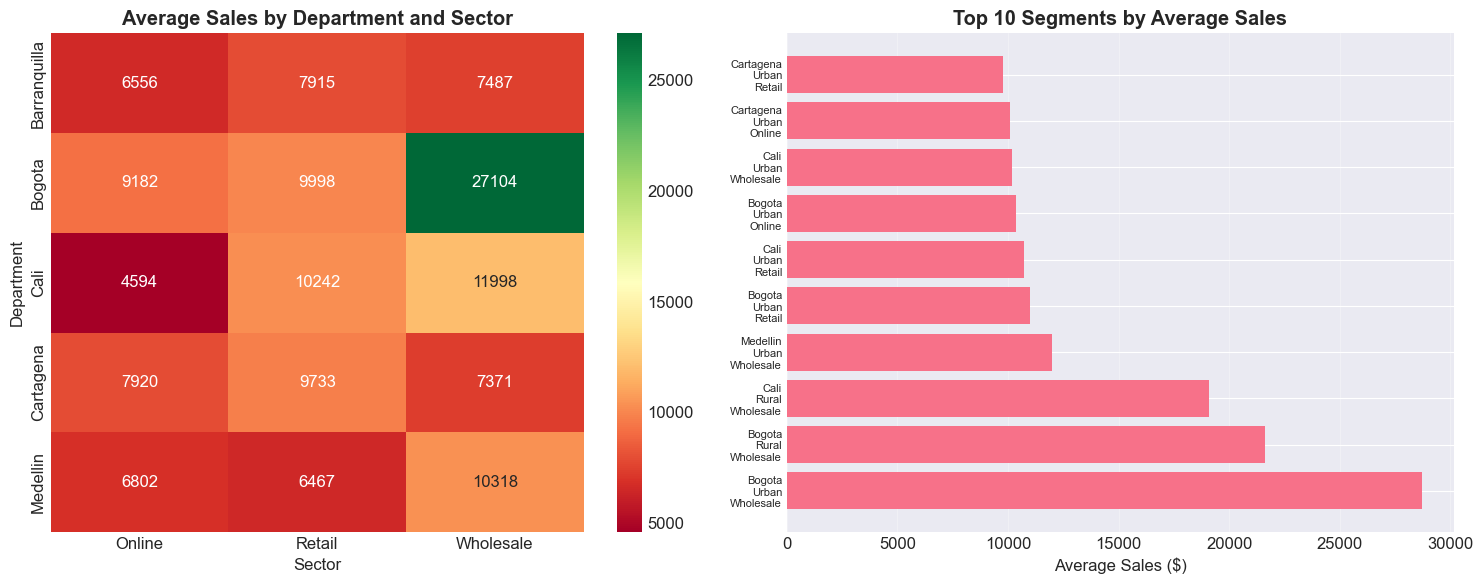

In [10]:
# Multiple segmentation - 3 dimensions
print("🌐 MULTIPLE SEGMENTATION (3 DIMENSIONS)")
print("="*60)

segments = df.groupby(['department', 'zone', 'sector']).agg({
    'sales': ['mean', 'sum', 'count'],
    'satisfaction': 'mean',
    'customer_age': 'mean'
}).round(2)

# Flatten columns
segments.columns = ['_'.join(col).strip() for col in segments.columns.values]
segments = segments.reset_index()

# Sort by average sales
top_segments = segments.sort_values('sales_mean', ascending=False).head(10)

print("\n🏆 TOP 10 SEGMENTS BY AVERAGE SALES:")
print(top_segments.to_string())

# Segment visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap of average sales by department and sector
pivot_sales = df.pivot_table(values='sales', 
                               index='department', 
                               columns='sector', 
                               aggfunc='mean')

sns.heatmap(pivot_sales, annot=True, fmt='.0f', cmap='RdYlGn', ax=axes[0])
axes[0].set_title('Average Sales by Department and Sector', fontweight='bold')
axes[0].set_xlabel('Sector')
axes[0].set_ylabel('Department')

# Barplot of top segments
top_segments['segment'] = (top_segments['department'] + '\n' + 
                              top_segments['zone'] + '\n' + 
                              top_segments['sector'])
axes[1].barh(range(len(top_segments)), top_segments['sales_mean'].values)
axes[1].set_yticks(range(len(top_segments)))
axes[1].set_yticklabels(top_segments['segment'].values, fontsize=8)
axes[1].set_xlabel('Average Sales ($)')
axes[1].set_title('Top 10 Segments by Average Sales', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [11]:
# Atypical behavior analysis in groups
print("🔍 ATYPICAL GROUP DETECTION")
print("="*60)

# Calculate statistics by group
stats_by_category = df.groupby('category').agg({
    'sales': ['mean', 'std', 'count'],
    'satisfaction': 'mean',
    'discount': 'mean'
}).round(2)

stats_by_category.columns = ['_'.join(col).strip() for col in stats_by_category.columns.values]

# Calculate coefficient of variation
stats_by_category['cv_sales'] = (stats_by_category['sales_std'] / 
                                     stats_by_category['sales_mean'] * 100).round(1)

print("\nStatistics by Category with Coefficient of Variation:")
print(stats_by_category)

# Identify categories with high variability
print("\n⚠️  Categories with High Variability (CV > 50%):")
high_variability = stats_by_category[stats_by_category['cv_sales'] > 50]
if len(high_variability) > 0:
    print(high_variability[['sales_mean', 'sales_std', 'cv_sales']])
    print("\n💡 These categories require deeper analysis - possible subsegments")
else:
    print("No categories with high variability found")

🔍 ATYPICAL GROUP DETECTION

Statistics by Category with Coefficient of Variation:
             sales_mean  sales_std  sales_count  satisfaction_mean  \
category                                                             
Clothing        8893.53   14411.06          241               7.29   
Electronics    13379.23   68084.82          274               7.41   
Food            8578.43   15275.63          255               7.45   
Home            7960.57   12798.80          230               7.46   

             discount_mean  cv_sales  
category                              
Clothing              5.08     162.0  
Electronics           5.02     508.9  
Food                  5.18     178.1  
Home                  5.26     160.8  

⚠️  Categories with High Variability (CV > 50%):
             sales_mean  sales_std  cv_sales
category                                    
Clothing        8893.53   14411.06     162.0
Electronics    13379.23   68084.82     508.9
Food            8578.43   15275.6

## 📋 Template for Delivery 1 - Practical Example

In [16]:
def generate_eda_report(df, project_name="Sales Analysis"):
    """
    Generates a complete EDA report following the Delivery 1 template
    """
    print("="*80)
    print(f"📊 COMPLETE EDA REPORT: {project_name}")
    print("="*80)
    print(f"\nDate: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
    print(f"Dataset: {df.shape[0]} rows × {df.shape[1]} columns")
    
    # 1. UNIVARIATE ANALYSIS
    print("\n" + "="*80)
    print("1️⃣ UNIVARIATE ANALYSIS (40%)")
    print("="*80)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols[:3]:  # Top 3 numeric variables
        print(f"\n📈 Variable: {col.upper()}")
        print("-"*40)
        
        data = df[col].dropna()
        
        # Statistics
        print(f"  • Count: {len(data)}")
        print(f"  • Mean: {data.mean():.2f}")
        print(f"  • Median: {data.median():.2f}")
        print(f"  • Std: {data.std():.2f}")
        print(f"  • Min/Max: {data.min():.2f} / {data.max():.2f}")
        
        # Distribution
        skewness = data.skew()
        if abs(skewness) < 0.5:
            dist_type = "Normal (symmetric)"
        elif skewness > 0.5:
            dist_type = "Right-skewed"
        else:
            dist_type = "Left-skewed"
        
        print(f"  • Distribution: {dist_type} (skewness={skewness:.3f})")
        
        # Outliers
        Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)]
        print(f"  • Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.1f}%)")
        
        # Data quality
        missing = df[col].isna().sum()
        print(f"  • Missing values: {missing} ({missing/len(df)*100:.1f}%)")
    
    # 2. BIVARIATE ANALYSIS
    print("\n" + "="*80)
    print("2️⃣ BIVARIATE ANALYSIS (40%)")
    print("="*80)
    
    # Main correlations
    corr_matrix = df[numeric_cols].corr()
    
    # Find the 3 strongest correlations (excluding diagonal)
    mask = np.triu(np.ones_like(corr_matrix), k=1)
    corr_values = corr_matrix.where(mask.astype(bool)).stack().sort_values(key=abs, ascending=False)
    
    print("\n🔗 Top 3 Strongest Correlations:")
    for i, (vars, corr) in enumerate(corr_values.head(3).items(), 1):
        var1, var2 = vars
        print(f"\n  {i}. {var1} ↔ {var2}")
        print(f"     • Correlation: {corr:.3f}")
        
        if abs(corr) > 0.7:
            interpretation = "Strong"
        elif abs(corr) > 0.3:
            interpretation = "Moderate"
        else:
            interpretation = "Weak"
        
        direction = "positive" if corr > 0 else "negative"
        print(f"     • Interpretation: {interpretation} {direction} relationship")
        print(f"     • Implication: Changes in {var1} are associated with changes in {var2}")
    
    # 3. MULTIVARIATE ANALYSIS
    print("\n" + "="*80)
    print("3️⃣ BASIC MULTIVARIATE ANALYSIS (20%)")
    print("="*80)
    
    # Segmentation by multiple variables
    if 'department' in df.columns and 'sector' in df.columns:
        print("\n🌐 Segmentation: Department × Sector")
        segmentation = df.groupby(['department', 'sector']).agg({
            'sales': 'mean'
        }).round(2)
        
        top_segments = segmentation.sort_values('sales', ascending=False).head(5)
        print("\nTop 5 Segments by Average Sales:")
        
        # Correct way to iterate over the grouped data
        for idx in top_segments.index:
            dept, sector = idx
            sales_value = top_segments.loc[idx, 'sales']
            print(f"  • {dept} - {sector}: ${sales_value:.2f}")
    
    # Generated hypotheses
    print("\n💡 HYPOTHESES GENERATED FOR FUTURE ANALYSIS:")
    print("-"*50)
    print("  1. Urban segments show greater sales variability")
    print("  2. Non-linear relationship exists between age and satisfaction")
    print("  3. Discount effect varies by product category")
    print("  4. Possible customer segmentation based on bimodal behavior")
    
    print("\n" + "="*80)
    print("📊 END OF EDA REPORT")
    print("="*80)

# Generate the report
generate_eda_report(df)

📊 COMPLETE EDA REPORT: Sales Analysis

Date: 2025-09-06 14:50
Dataset: 1000 rows × 10 columns

1️⃣ UNIVARIATE ANALYSIS (40%)

📈 Variable: SALES
----------------------------------------
  • Count: 1000
  • Mean: 9827.68
  • Median: 3044.50
  • Std: 37661.82
  • Min/Max: 33.56 / 1076640.99
  • Distribution: Right-skewed (skewness=23.229)
  • Outliers: 121 (12.1%)
  • Missing values: 0 (0.0%)

📈 Variable: CUSTOMER_AGE
----------------------------------------
  • Count: 1000
  • Mean: 39.09
  • Median: 35.00
  • Std: 16.21
  • Min/Max: 10.00 / 73.00
  • Distribution: Normal (symmetric) (skewness=0.179)
  • Outliers: 0 (0.0%)
  • Missing values: 0 (0.0%)

📈 Variable: SATISFACTION
----------------------------------------
  • Count: 950
  • Mean: 7.40
  • Median: 7.40
  • Std: 1.43
  • Min/Max: 3.20 / 10.00
  • Distribution: Normal (symmetric) (skewness=-0.161)
  • Outliers: 3 (0.3%)
  • Missing values: 50 (5.0%)

2️⃣ BIVARIATE ANALYSIS (40%)

🔗 Top 3 Strongest Correlations:

  1. sales ↔ dis